# Classification of Light, Deep, REM, Wake, and Movement

Database source: 
    
    Goldberger AL, Amaral LAN, Glass L, Hausdorff JM, Ivanov PCh, Mark RG, Mietus JE, Moody GB, Peng C-K, Stanley HE. PhysioBank, PhysioToolkit, and PhysioNet: Components of a New Research Resource for Complex Physiologic Signals. Circulation 101(23):e215-e220 [Circulation Electronic Pages; http://circ.ahajournals.org/content/101/23/e215.full]; 2000 (June 13).


In [1]:
from __future__ import division
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal as ss
import seaborn as sns
from scipy.ndimage import convolve1d
from scipy.stats import entropy
import itertools
import sleep_utils as su
import pickle

# import psycopg2
import datetime  
import time 
import wfdb
import glob


from biosppy.signals import ecg
import nolds

%matplotlib inline
sns.set()
pd.set_option("display.max_columns", None)
%load_ext autoreload
%autoreload 2

### Load signals

In [2]:
data_dir = '../data/PSG_database/'

features_dir = data_dir + "PSG_features/"

resp_data_set_epochs = pickle.load(open(features_dir + "resp_data_set_epochs.pkl", "rb" ) )
ecg_data_set_epochs = pickle.load(open(features_dir + "ecg_data_set_epochs.pkl", "rb" ) )
bp_data_set_epochs = pickle.load(open(features_dir + "bp_data_set_epochs.pkl", "rb" ) )


In [3]:
data_keys = pickle.load(open(features_dir + "data_keys.pkl", "rb" ) )

### Load features

#### Previous stages

In [4]:
feature_prev_stage_light = pickle.load(open(features_dir + "feature_prev_stage_light.pkl", "rb" ) )
feature_prev_stage_deep = pickle.load(open(features_dir + "feature_prev_stage_deep.pkl", "rb" ) )
feature_prev_stage_rem = pickle.load(open(features_dir + "feature_prev_stage_rem.pkl", "rb" ) )
feature_prev_stage_wake = pickle.load(open(features_dir + "feature_prev_stage_wake.pkl", "rb" ) )
feature_prev_stage_move = pickle.load(open(features_dir + "feature_prev_stage_move.pkl", "rb" ) )

#### Respiration signal

In [5]:
feature_resp_rate = pickle.load(open(features_dir + "feature_resp_rate.pkl", "rb" ) )
feature_hist_resp = pickle.load(open(features_dir + "feature_hist_resp.pkl", "rb" ) )
feature_mean_vs_std_resp = pickle.load(open(features_dir + "feature_mean_vs_std_resp.pkl", "rb" ) )
feature_mean_vs_std_p2p_dur_resp = pickle.load(open(features_dir + "feature_mean_vs_std_p2p_dur_resp.pkl", "rb" ) )
feature_mean_vs_std_amp_resp = pickle.load(open(features_dir + "feature_mean_vs_std_amp_resp.pkl", "rb" ) )
feature_max_vs_mean_amp_resp = pickle.load(open(features_dir + "feature_max_vs_mean_amp_resp.pkl", "rb" ) )
feature_min_vs_mean_amp_resp = pickle.load(open(features_dir + "feature_min_vs_mean_amp_resp.pkl", "rb" ) )
feature_sampen_resp = pickle.load(open(features_dir + "feature_sampen_resp.pkl", "rb" ) )


#### ECG signal

In [6]:
feature_heart_rate = pickle.load(open(features_dir + "feature_heart_rate.pkl", "rb" ) )
feature_heart_rate_var = pickle.load(open(features_dir + "feature_heart_rate_var.pkl", "rb" ) )
feature_hist_ecg = pickle.load(open(features_dir + "feature_hist_ecg.pkl", "rb" ) )
feature_mean_vs_std_ecg = pickle.load(open(features_dir + "feature_mean_vs_std_ecg.pkl", "rb" ) )
feature_mean_vs_std_p2p_dur_ecg = pickle.load(open(features_dir + "feature_mean_vs_std_p2p_dur_ecg.pkl", "rb" ) )
feature_mean_vs_std_amp_ecg = pickle.load(open(features_dir + "feature_mean_vs_std_amp_ecg.pkl", "rb" ) )
feature_max_vs_mean_amp_ecg = pickle.load(open(features_dir + "feature_max_vs_mean_amp_ecg.pkl", "rb" ) )
feature_min_vs_mean_amp_ecg = pickle.load(open(features_dir + "feature_min_vs_mean_amp_ecg.pkl", "rb" ) )
feature_sampen_ecg = pickle.load(open(features_dir + "feature_sampen_ecg.pkl", "rb" ) )

### Compile features 

In [7]:
features = [feature_resp_rate, feature_hist_resp, feature_heart_rate, 
            feature_heart_rate_var, feature_hist_ecg, 
            feature_mean_vs_std_resp, feature_mean_vs_std_ecg,
            feature_mean_vs_std_p2p_dur_resp, feature_mean_vs_std_p2p_dur_ecg,
            feature_mean_vs_std_amp_resp, feature_max_vs_mean_amp_resp, feature_min_vs_mean_amp_resp,
            feature_mean_vs_std_amp_ecg, feature_max_vs_mean_amp_ecg, feature_min_vs_mean_amp_ecg, 
            feature_sampen_resp]

f_merge = []
for f in features:
    fm = []
    for key in data_keys:
        fm += list(f[key]['_feat'])
    f_merge.append(np.reshape(fm, [len(fm), -1]))
    
sleep_features = np.hstack(f_merge)


In [8]:
annot_data_set = pickle.load(open(features_dir + "annot_data_set.pkl", "rb" ) )

In [9]:
merge_labels = np.hstack([annot_data_set[key] for key in data_keys])

merge_labels[np.where(merge_labels == '1')] = 1
merge_labels[np.where(merge_labels == '2')] = 2
merge_labels[np.where(merge_labels == '3')] = 3
merge_labels[np.where(merge_labels == '4')] = 3
merge_labels[np.where(merge_labels == 'R')] = 4
merge_labels[np.where(merge_labels == 'W')] = 5
merge_labels[np.where(merge_labels == 'M')] = 6

In [10]:
sleep_features = np.array(sleep_features, dtype = float)
sleep_data = sleep_features[np.isfinite(sleep_features).all(axis=1)]
sleep_labels = np.reshape(merge_labels, [len(merge_labels), 1])[np.isfinite(sleep_features).all(axis=1)]

## Classify

In [11]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

/Users/eventura/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [13]:
## Feature selection
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

In [14]:
sleep_data_scaled = StandardScaler().fit_transform(sleep_data)
train_set, test_set, train_label, test_label = train_test_split(sleep_data_scaled, sleep_labels, test_size=0.33, random_state=42)

train_label = np.ndarray.flatten(train_label).astype(float)
test_label = np.ndarray.flatten(test_label).astype(float)

In [15]:
names = ["Decision Tree", "Random Forest", "AdaBoost", "Linear SVM"]

classifiers = [
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=10, n_estimators=10, max_features=1),
    AdaBoostClassifier(),
    SVC(kernel="linear", C=0.025)]

In [16]:
for i in np.arange(len(classifiers)):
    print('Training ' + names[i])
    clf = classifiers[i]
    clf.fit(train_set, np.ndarray.flatten(train_label))
    prediction = clf.predict(test_set)
    print("Accuracy: {0:.4f}%".format(100*accuracy_score(test_label, prediction)))
    print(confusion_matrix(test_label, prediction, labels = np.unique(test_label)))
    print('\n')
    

Training Decision Tree
Accuracy: 52.9430%
[[ 105  377    0    0  115    0]
 [  30 1108    6    1  120    0]
 [   2  209    5    0   17    0]
 [   9  151    1   20   35    0]
 [  59  424    0    0  516    0]
 [   0    2    0    0    1    0]]


Training Random Forest
Accuracy: 60.2475%
[[ 160  284    0    0  153    0]
 [  50 1042   23    2  148    0]
 [   2  154   52    2   23    0]
 [  14  153    1   13   35    0]
 [  38  230    1    1  729    0]
 [   0    2    0    0    1    0]]


Training AdaBoost
Accuracy: 44.3405%
[[ 42 201  17   0 337   0]
 [ 53 689  91   2 426   4]
 [  1  98 100   0  34   0]
 [ 17 103  32   0  63   1]
 [ 40 225  93   1 637   3]
 [  0   0   0   0   2   1]]


Training Linear SVM
Accuracy: 52.8826%
[[142 294   0   0 161   0]
 [ 63 983   1   0 218   0]
 [  5 196   0   0  32   0]
 [ 10 176   0   0  30   0]
 [ 55 316   1   0 627   0]
 [  0   1   0   0   2   0]]




### Feature selection using f_regression

In [17]:
num_feats = np.arange(np.array(train_set, dtype = float).shape[1], 0, -1)
accuracies = np.zeros([len(classifiers), len(num_feats)])

In [18]:
for i in range(len(num_feats)):
    feat_filter = SelectKBest(f_regression, k=num_feats[i])
    feat_filter.fit(np.array(train_set, dtype = float), train_label)
    train_set_filt = feat_filter.transform(train_set.astype(float))
    test_set_filt = feat_filter.transform(test_set.astype(float))

    selected = feat_filter.transform(np.reshape(np.arange(np.array(train_set, dtype = float).shape[1]), [1, -1]))
    select_scores = feat_filter.transform(np.reshape(feat_filter.scores_, [1, -1]))
    print('Selected {} features ranked by score: \t {}'.format(num_feats[i], selected[0][np.fliplr(select_scores.argsort())[0]]))
    
    for j in range(len(classifiers)):
        clf = classifiers[j]
        clf.fit(train_set_filt, train_label)
        prediction = clf.predict(test_set_filt)
        
        accuracies[j, i] = accuracy_score(test_label, prediction)

Selected 24 features ranked by score: 	 [ 0 19 18  7  6 22 21 10  5 11  4  1 23  2 12 16  8  3 20 14 17 13 15  9]
Selected 23 features ranked by score: 	 [ 0 19 18  7  6 21 22 10  5 11  4  1 23  2 12 16  8  3 20 14 17 13 15]
Selected 22 features ranked by score: 	 [ 0 19 18  7  6 22 21 10  5 11  4  1 23  2 12 16  8  3 20 14 17 13]
Selected 21 features ranked by score: 	 [ 0 19 18  7  6 22 21 10  5 11  4  1 23  2 12 16  8  3 20 14 17]
Selected 20 features ranked by score: 	 [ 0 19 18  7  6 22 21 10  5 11  4  1 23  2 12 16  8  3 20 14]
Selected 19 features ranked by score: 	 [ 0 19 18  7  6 22 21 10  5 11  4  1 23  2 12 16  8  3 20]
Selected 18 features ranked by score: 	 [ 0 19 18  7  6 21 22 10  5 11  4  1 23  2 12 16  8  3]
Selected 17 features ranked by score: 	 [ 0 19 18  7  6 22 21 10  5 11  4  1 23  2 12 16  8]
Selected 16 features ranked by score: 	 [ 0 19 18  7  6 22 21 10  5 11  4  1 23  2 12 16]
Selected 15 features ranked by score: 	 [ 0 19 18  7  6 22 21 10  5 11  4  1 23  2

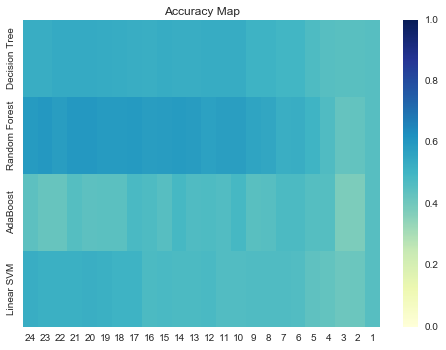

In [19]:
from seaborn import heatmap

heatmap(accuracies, vmin=0, vmax = 1, yticklabels = names, xticklabels=num_feats, cmap="YlGnBu")
plt.title('Accuracy Map')

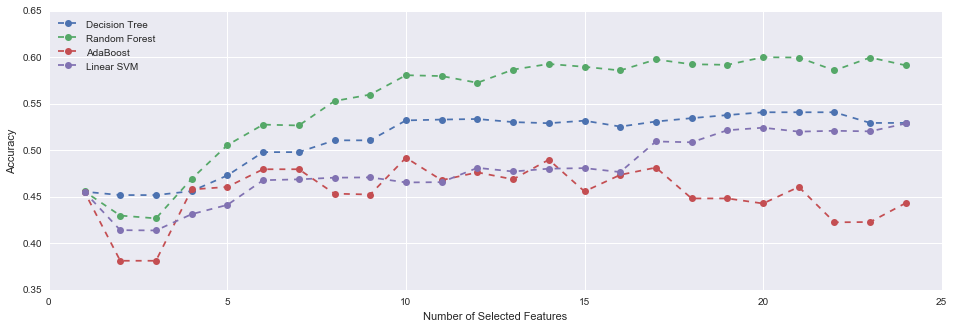

In [20]:
plt.figure(figsize=[16, 5])
for i in range(len(accuracies)):
    plt.plot(num_feats, accuracies[i], 'o--', label = names[i])
plt.legend(loc = 'best')
plt.ylabel('Accuracy')
plt.xlabel('Number of Selected Features')
# plt.xlim([1, 20])
# heatmap(accuracies, vmin=0, vmax = 1, yticklabels = names, xticklabels=num_feats, cmap="YlGnBu")
# plt.title('Accuracy Map')

In [21]:
np.max(accuracies), np.where(accuracies == np.max(accuracies))

(0.60006036824630249, (array([1]), array([4])))

Decision Tree
Optimal number of features : 7
Maximum accuracy : 0.530041%


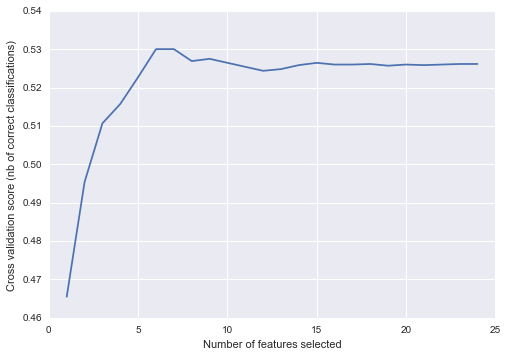

Random Forest
Optimal number of features : 8
Maximum accuracy : 0.628313%


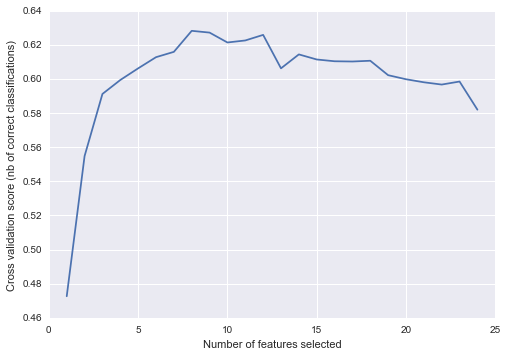

AdaBoost
Optimal number of features : 24
Maximum accuracy : 0.448846%


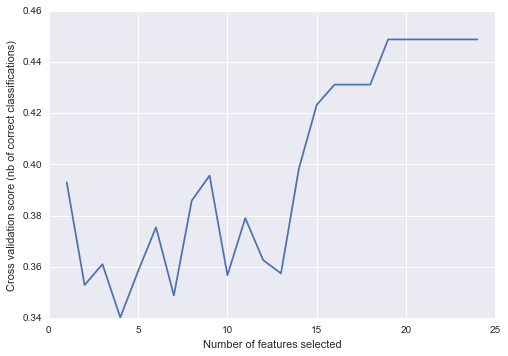

Linear SVM
Optimal number of features : 19
Maximum accuracy : 0.528545%


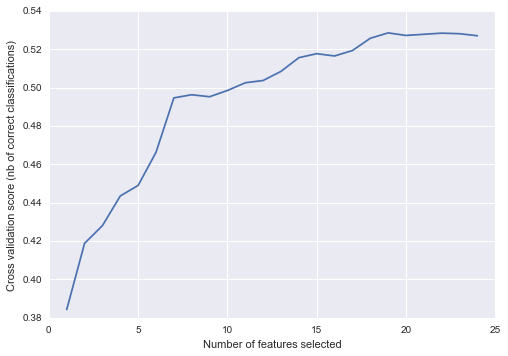

In [22]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification

names = ["Decision Tree", "Random Forest", "AdaBoost", "Linear SVM"]

classifiers = [
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=10, n_estimators=10, max_features=1),
    AdaBoostClassifier(),
    SVC(kernel="linear", C=0.025)]

for i in np.arange(len(classifiers)):
    clf = classifiers[i]
    rfecv = RFECV(estimator=clf, step=1, cv=StratifiedKFold(3),
                  scoring='accuracy')
    rfecv.fit(train_set, train_label)
    print(names[i])
    print("Optimal number of features : %d" % rfecv.n_features_)
    print("Maximum accuracy : {0:4f}%".format(max(rfecv.grid_scores_)))


    # Plot number of features VS. cross-validation scores
    plt.figure()
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score (nb of correct classifications)")
    plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
    plt.show()

In [23]:
## Oversample using smote

In [24]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(kind='regular')
# train_set_smote, train_label_smote = sm.fit_sample(train_set, train_label)

In [25]:
def smote_all_minority(train_set, train_label):
    sm = SMOTE(kind='regular')

    majority = max(set(train_label), key=list(train_label).count)
    major_index = np.where(train_label==majority)[0]
    minorities = list(set(train_label) - set([majority]))
    
    majority_data = train_set[major_index, :]
    majority_labels = train_label[major_index]
    
    oversampled_data = {majority: majority_data}
    oversampled_labels = {majority: majority_labels}
    
    for i in minorities:
        minor_index = np.where(train_label==i)[0]
        reduced_features = np.concatenate((train_set[major_index, :], train_set[minor_index, :]))
        reduced_labels = np.concatenate((train_label[major_index], train_label[minor_index]))  
        train_set_smote, train_label_smote = sm.fit_sample(reduced_features, reduced_labels)
        
        new_minor_index = np.where(train_label_smote==i)[0]

        oversampled_data[i] = train_set_smote[new_minor_index, :]
        oversampled_labels[i] = train_label_smote[new_minor_index]
        
    return oversampled_data, oversampled_labels

In [26]:
oversample_data, oversample_label = smote_all_minority(train_set, train_label)
train_set_smote = []
train_label_smote = []

for k in oversample_data.keys():
    train_set_smote.append(oversample_data[k])
    train_label_smote.append(oversample_label[k])
    
train_set_smote = np.vstack(train_set_smote)
train_label_smote = np.hstack(train_label_smote)

In [27]:
for i in np.arange(len(classifiers)):
    print('Training ' + names[i])
    clf = classifiers[i]
    clf.fit(train_set_smote, np.ndarray.flatten(train_label_smote))
    prediction = clf.predict(test_set)
    print("Accuracy: {0:.4f}%".format(100*accuracy_score(test_label, prediction)))
    print(confusion_matrix(test_label, prediction, labels = np.unique(test_label)))
    print('\n')

Training Decision Tree
Accuracy: 29.0673%
[[ 45  28  41 233 190  60]
 [ 47 226 261 295 271 165]
 [  3   7 144  25  34  20]
 [  8   8  35  97  33  35]
 [ 45  34 109 195 450 166]
 [  0   1   0   0   1   1]]


Training Random Forest
Accuracy: 54.4823%
[[307  95  21  44 125   5]
 [197 605 216 111 119  17]
 [  7  36 169   6  14   1]
 [ 31  28  19 122  16   0]
 [169 104  64  44 602  16]
 [  0   2   0   0   1   0]]


Training AdaBoost
Accuracy: 37.4887%
[[153 102 113  70 148  11]
 [247 438 277 141 138  24]
 [  8  50 156   6  10   3]
 [ 24  72  52  49  18   1]
 [128  71 254  70 444  32]
 [  0   1   0   0   0   2]]


Training Linear SVM
Accuracy: 40.4769%
[[297  52  46  76  97  29]
 [205 370 282 221 109  78]
 [ 13  18 158  33   5   6]
 [ 23  26  34 114  10   9]
 [189  61 111 111 400 127]
 [  0   0   0   1   0   2]]




Decision Tree
Optimal number of features : 9
Maximum accuracy : 0.503031%


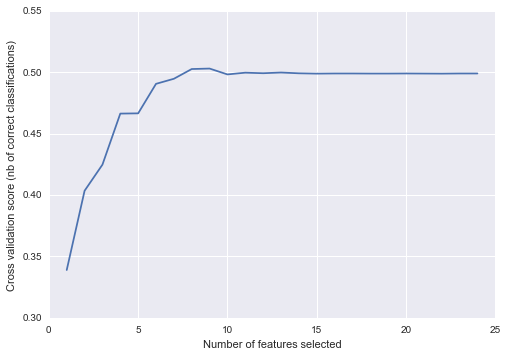

Random Forest
Optimal number of features : 17
Maximum accuracy : 0.754742%


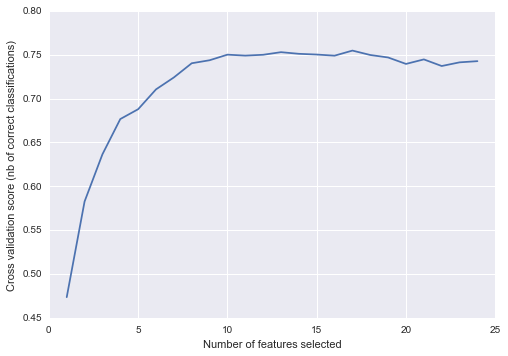

AdaBoost
Optimal number of features : 24
Maximum accuracy : 0.478281%


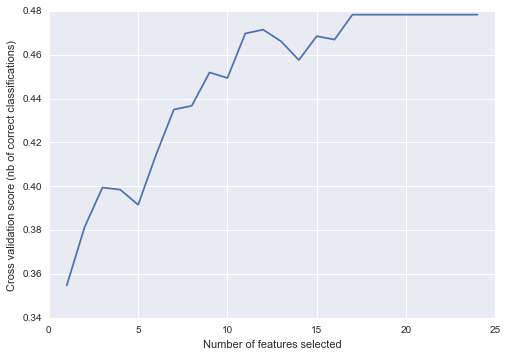

Linear SVM
Optimal number of features : 24
Maximum accuracy : 0.559188%


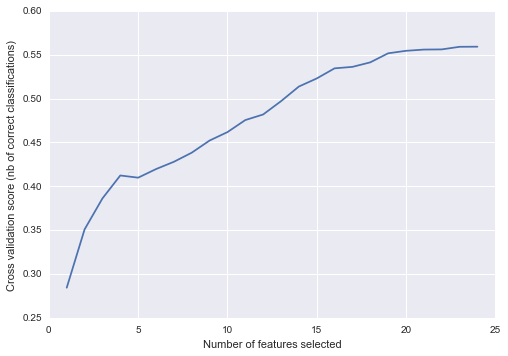

In [28]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification

names = ["Decision Tree", "Random Forest", "AdaBoost", "Linear SVM"]

classifiers = [
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=10, n_estimators=10, max_features=1),
    AdaBoostClassifier(),
    SVC(kernel="linear", C=0.025)]


training_data = train_set_smote
train_data_label = train_label_smote

for i in np.arange(len(classifiers)):
    clf = classifiers[i]
    rfecv = RFECV(estimator=clf, step=1, cv=StratifiedKFold(3),
                  scoring='accuracy')
    rfecv.fit(training_data, train_data_label)
    print(names[i])
    print("Optimal number of features : %d" % rfecv.n_features_)
    print("Maximum accuracy : {0:4f}%".format(max(rfecv.grid_scores_)))
    # Plot number of features VS. cross-validation scores
    plt.figure()
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score (nb of correct classifications)")
    plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
    plt.show()
    